In [ ]:
#!pip install timm

In [1]:
!pip install opencv-python
!pip install opencv-contrib-python
!pip install opencv-python-headless
!pip install opencv-contrib-python-headless
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 64.7 MB/s eta 0:00:00


In [2]:
#import google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
from collections import OrderedDict
import torchvision

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
import rasterio as rio

import cv2
import PIL
import os
import random

### Dataset


In [4]:
def filter_min_components(binIMG, minSize=100, it_dilate=3, it_erode=1):
  # Apply the Component analysis function
  (totalLabels, label_ids, values, centroid) = cv2.connectedComponentsWithStats(binIMG, 4, cv2.CV_32S)

  # Initialize a new image to store all the output components
  output_temp = np.zeros(binIMG.shape, dtype="uint8")

  # Loop through each component
  for i in range(1, totalLabels):
      area = values[i, cv2.CC_STAT_AREA]
      if (area > minSize):
          # Labels stores all the IDs of the components on the each pixel
          # It has the same dimension as the threshold
          # So we'll check the component
          # then convert it to 255 value to mark it white
          componentMask = (label_ids == i).astype("uint8")

          # Creating the Final output mask
          output_temp = cv2.bitwise_or(output_temp, componentMask)
  #dilate 3 times + erode 1 to improve the shape
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
  output = cv2.dilate(output_temp, kernel, iterations=it_dilate)
  output = cv2.erode(output, kernel, iterations=it_erode)
  return output

In [5]:
def load_data_agave(batch_size, channels, norm = True):
  root = '/content/drive/MyDrive/DCC - Diego Villatoro Gerónimo/'
  train_data = []
  folder = root+"Datos Tesis Referencia/Datasets/Zone3/"

  file_names = os.listdir(folder)
  file_names = [file_name for file_name in file_names if file_name[-3:]=='tif']
  random.shuffle(file_names)

  file_names_train = file_names[0:int(0.9*len(file_names))]
  file_names_test = file_names[int(0.9*len(file_names)):]

  for file_name in file_names_train:
    with rio.open(folder+file_name) as img :
      img_full = img.read()
    #shape : Nc, H, W
    BGR = img_full[[0,1,2], :,:]
    X = img_full[[3,4,6], :,:]
    if norm:
      gamma = 0.6
      BGR = pow(BGR, gamma)
    X = np.concatenate((BGR, X), axis=0)

    arvi_temp = np.copy(img_full[6, :, :])
    ret,seg = cv2.threshold((255*arvi_temp).astype('uint8'),171,255,cv2.THRESH_BINARY)
    seg = filter_min_components(seg, minSize=100, it_dilate=0, it_erode=0)
    contours, hierarchy = cv2.findContours(seg, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    threshold_area = 10     #threshold area
    newContours2=[]
    for cnt in contours:
      newContours2.append(cnt) if cv2.contourArea(cnt) > threshold_area else newContours2
    cv2.drawContours(arvi_temp, newContours2, -1, (1), 1)
    arvi_temp = np.expand_dims(arvi_temp, axis=0)
    X = np.concatenate((X, arvi_temp), axis=0)

    y = img_full[7, :,:]
    X = X[channels, :,:]
    train_data.append([X, y])

  test_data = []
  for file_name in file_names_test:
    with rio.open(folder+file_name) as img :
      img_full = img.read()
    #shape : Nc, H, W
    BGR = img_full[[0,1,2], :,:]
    X = img_full[[3,4,6], :,:]
    if norm:
      gamma = 0.6
      BGR = pow(BGR, gamma)
    X = np.concatenate((BGR, X), axis=0)

    arvi_temp = np.copy(img_full[6, :, :])
    ret,seg = cv2.threshold((255*arvi_temp).astype('uint8'),171,255,cv2.THRESH_BINARY)
    seg = filter_min_components(seg, minSize=100, it_dilate=0, it_erode=0)
    contours, hierarchy = cv2.findContours(seg, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    threshold_area = 10     #threshold area
    newContours2=[]
    for cnt in contours:
      newContours2.append(cnt) if cv2.contourArea(cnt) > threshold_area else newContours2
    cv2.drawContours(arvi_temp, newContours2, -1, (1), 1)
    arvi_temp = np.expand_dims(arvi_temp, axis=0)
    X = np.concatenate((X, arvi_temp), axis=0)

    y = img_full[7, :,:]
    X = X[channels, :,:]
    test_data.append([X, y])

  train_iter = DataLoader(train_data, shuffle=True, batch_size=batch_size)
  test_iter = DataLoader(test_data, shuffle=True, batch_size=batch_size)

  return train_iter, test_iter

##Unet model

In [6]:
def accuracy(y_hat, y):
  # y_hat : [batch size, n classes]
  # y : [batch size]
  #compute the number of correct predictions
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
    # y_hat : [batch size]
  cmp = y_hat.type(y.dtype)==y
  #cmp = np.logical_and((y_hat.type(y.dtype)==y).cpu() , (y!=torch.zeros_like(y)).cpu() )
  #a = float(cmp.type(y.dtype).sum())
  #b = float((y!=torch.zeros_like(y)).type(y.dtype).sum())
  return float(cmp.type(y.dtype).sum())/ (len(y))

In [7]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ).to(device)

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        ).to(device)

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2).to(device)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1).to(device)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits = logits.permute(0, 2, 3, 1)
        # X: batch_size, H, W, num_classes
        return logits


##Train Epoch

In [9]:
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes


In [32]:
def train(model, iterator, optimizer, ce_loss, dice_loss, num_classes, clip):

    model.train()

    epoch_loss = 0
    Acc = 0.0

    for i, batch in enumerate(iterator):
        X, y = batch
        # X: batch_size, N channels, height, weight
        # y: batch_size

        y = y.type(torch.LongTensor)   # casting to long
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() # Zero your gradients for every batch!

        output = model(X) # Make predictions for this batch
        # output: batch_size, H, W, num_classes
        output = output.contiguous().view(-1, num_classes)
        y = y.contiguous().view(-1)
        # Compute the loss and its gradients
        loss_ce = ce_loss(output, y)
        loss_dice = dice_loss(output, y, softmax=True)
        loss = 0.5 * loss_ce + 0.5 * loss_dice

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Adjust learning weights
        optimizer.step()
        epoch_loss += loss.item()

        Acc += accuracy(output, y)

    #return epoch loss mean and accuracy mean of all the batches
    return epoch_loss / (i+1), Acc/ (i+1)

In [11]:
def evaluate(model, iterator, ce_loss, dice_loss, num_classes, metrics_s=False):

    model.eval()

    epoch_loss = 0
    Acc = 0.0

    dat = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():

      for i, batch in enumerate(iterator):
          X, y = batch
          y = y.type(torch.LongTensor)   # casting to long
          X, y = X.to(device), y.to(device)
          # X: batch_size, N channels, height, weight
          # y: batch_size
          optimizer.zero_grad() # Zero your gradients for every batch!
          output = model(X) # Make predictions for this batch
          # output: batch_size, H, W, num_classes
          output = output.contiguous().view(-1, num_classes)
          y = y.view(-1)

          loss_ce = ce_loss(output, y)
          loss_dice = dice_loss(output, y, softmax=True)
          loss = 0.5 * loss_ce + 0.5 * loss_dice

          if metrics_s:
            y_hat = output.argmax(axis=1)
            confusion_mat = confusion_matrix(y.cpu(), y_hat.cpu(), labels=list(range(num_classes)))
            _metrics = metrics(confusion_mat)
            Acc_, specificity, recall, precision, iou, dice, tn, fp, fn, tp = _metrics
            data = np.array([Acc_, specificity, recall, precision, iou, dice])
            dat += data

          epoch_loss += loss.item()
          Acc += accuracy(output, y)

    #return epoch loss mean and accuracy mean of all the batches
    if metrics_s:
      return epoch_loss / (i+1), Acc/ (i+1), dat/(i+1)
    else:
      return epoch_loss / (i+1), Acc/ (i+1)

In [12]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [13]:
from sklearn.metrics import confusion_matrix

def metrics(confusion: np.ndarray) -> tuple:
    """
    Return metrics evaluating a categorical classification task.
    Args:
        confusion: the confusion matrix between ground truth and predictions
        mask: the mask to use for the metrics
    Returns:
        a tuple of metrics for evaluation:
        -   float: the global accuracy
        -   ndarray: a vector representing the per class Accuracy
        -   ndarray: a vector representing the per class I/U
    """
    # calculate the global accuracy from the confusion matrix
    #accuracy = get_accuracy(confusion)
    # Confusion matrix
    tn, fp, fn, tp = confusion.ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn) if (tp+tn+fp+fn)!=0 else 0
    specificity = tn/(tn+fp) if (tn+fp)!=0 else 0
    recall = tp/(tp+fn) if (tp+fn)!=0 else 0
    precision = tp/(tp+fp) if (tp+fp)!=0 else 0
    iou = tp/(tp+fn+fp) if (tp+fn+fp)!=0 else 0
    dice = 2*tp/(2*tp+fp+fn) if (2*tp+fp+fn)!=0 else 0

    return accuracy*100, specificity*100, recall*100, precision*100, iou*100, dice*100, tn, fp, fn, tp

##Load data

In [24]:
batch_size = 16
norm = True #gamma normalization
channels = [0,1,2]
train_iter, test_iter = load_data_agave(batch_size, channels, norm)
##################
#B -> Ch0
#G -> Ch1
#R -> Ch2
#Re -> Ch3
#NIR -> Ch4
#ARVI -> Ch5 (ARVI with Shadow Improvement)
#ARVI with contours -> Ch6
##################

In [25]:
for i, batch in enumerate(test_iter):
    imgs, labels = batch
    print(imgs.shape)
    break

torch.Size([16, 3, 224, 224])


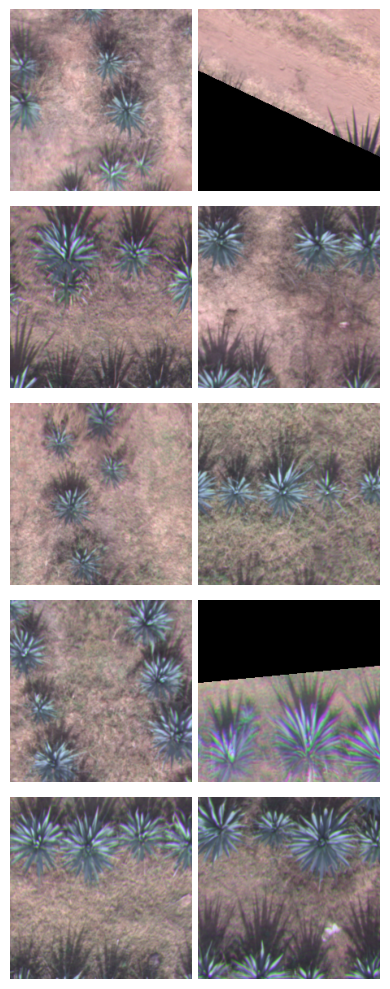

In [26]:
r, c = 5, 2
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, tar = imgs[ix], labels[ix]
        img = img[0:3,::]
        img = img.permute(1, 2, 0)/img.max()
        img = img[:, :, [2,1,0]]
        ax.axis("off")
        ax.imshow(img, cmap="gray")
        #ax.set_title(label.item())
plt.tight_layout()
plt.show()

##Model Initialization

In [27]:
#torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes=2
n_channels=len(channels)

model = UNet(n_channels, n_classes = num_classes, bilinear=False)

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 31,037,698 trainable parameters


In [29]:
#import timm
#from timm.models.layers import trunc_normal_

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        #print(m)
        nn.init.xavier_uniform_(m.weight.data)

    #if isinstance(m, nn.Linear):
    #    trunc_normal_(m.weight, std=0.02)
    #    if isinstance(m, nn.Linear) and m.bias is not None:
    #        nn.init.constant_(m.bias, 0)
    #elif isinstance(m, nn.LayerNorm):
    #    nn.init.constant_(m.bias, 0)
    #    nn.init.constant_(m.weight, 1.0)

In [30]:
model.apply(initialize_weights);

In [31]:
ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(num_classes)

#criterion = nn.BCELoss()
LEARNING_RATE = 0.001
optimizer_name = 'RMSprop'
if optimizer_name=='Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
elif optimizer_name=='SGD':
  optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001)
elif optimizer_name=='RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=False) #amp

##Training

In [ ]:
#del model
#torch.cuda.empty_cache()

In [33]:
num_epochs = 100
CLIP = 1

best_valid_loss = float('inf')
losses_train = []
losses_test = []
accs_train = []
accs_test = []
data_each_epoch = []
for epoch in range(num_epochs):

    start_time = time.time()

    train_loss, acc_train = train(model, train_iter, optimizer, ce_loss, dice_loss, num_classes, clip=CLIP)
    test_loss, acc_test, data = evaluate(model, test_iter, ce_loss, dice_loss, num_classes, True)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if test_loss < best_valid_loss:
        best_valid_loss = test_loss
        torch.save(model.state_dict(), 'transUnet-model-'+str(num_epochs)+'-epochs-'+optimizer_name+'.pt')
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accs_train.append(acc_train)
    accs_test.append(acc_test)
    data_each_epoch.append(data)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss {train_loss:.3f}, train accuracy {acc_train:.3f}, test accuracy {acc_test:.3f}')

Epoch: 01 | Time: 0m 38s
	Train Loss 0.112, train accuracy 0.946, test accuracy 0.969
Epoch: 02 | Time: 0m 38s
	Train Loss 0.058, train accuracy 0.972, test accuracy 0.970
Epoch: 03 | Time: 0m 39s
	Train Loss 0.055, train accuracy 0.973, test accuracy 0.964
Epoch: 04 | Time: 0m 38s
	Train Loss 0.057, train accuracy 0.972, test accuracy 0.928
Epoch: 05 | Time: 0m 38s
	Train Loss 0.057, train accuracy 0.972, test accuracy 0.962
Epoch: 06 | Time: 0m 37s
	Train Loss 0.056, train accuracy 0.972, test accuracy 0.921
Epoch: 07 | Time: 0m 36s
	Train Loss 0.057, train accuracy 0.972, test accuracy 0.961
Epoch: 08 | Time: 0m 36s
	Train Loss 0.056, train accuracy 0.972, test accuracy 0.968
Epoch: 09 | Time: 0m 36s
	Train Loss 0.056, train accuracy 0.973, test accuracy 0.964
Epoch: 10 | Time: 0m 36s
	Train Loss 0.056, train accuracy 0.973, test accuracy 0.964
Epoch: 11 | Time: 0m 35s
	Train Loss 0.057, train accuracy 0.972, test accuracy 0.970
Epoch: 12 | Time: 0m 35s
	Train Loss 0.055, train accu

In [34]:
import pandas as pd
df = pd.DataFrame(data_each_epoch, columns=['Acc', 'Specificity', 'Recall', 'Precision', 'IoU_Agave', 'DICE'])
#df.to_csv('/content/drive/MyDrive/DCC - Diego Villatoro Gerónimo/Datos Tesis Referencia/Mapas/metrics_transUnet.csv', index=False)
root = '/content/drive/MyDrive/DCC - Diego Villatoro Gerónimo/Datos Tesis Referencia/Mapas/Unet/'
df.to_csv(root+'metrics_Unet.csv', index=False)
torch.save(model.state_dict(), root+'Unet-model-'+str(num_epochs)+'-epochs-'+optimizer_name+'.pt')
df

,Acc,Specificity,Recall,Precision,IoU_Agave,DICE
0,96.929834,98.509830,88.501264,91.890859,82.075343,90.152506
1,96.993058,98.057347,91.167024,89.862696,82.653458,90.493982
2,96.364799,99.481317,79.787407,96.681948,77.651590,87.404408
3,92.771181,91.670255,98.572930,69.052119,68.367748,81.200956
4,96.221402,99.540294,78.243383,97.011367,76.404102,86.603951
...,...,...,...,...,...,...
95,96.879787,97.458371,93.789992,87.486505,82.699927,90.521125
96,97.080283,97.999522,92.086152,89.809683,83.362408,90.920921
97,96.185454,99.517904,77.997137,96.897733,76.090258,86.387253
98,96.994796,97.284473,95.365014,87.001494,83.465378,90.984679


<function matplotlib.pyplot.show(close=None, block=None)>

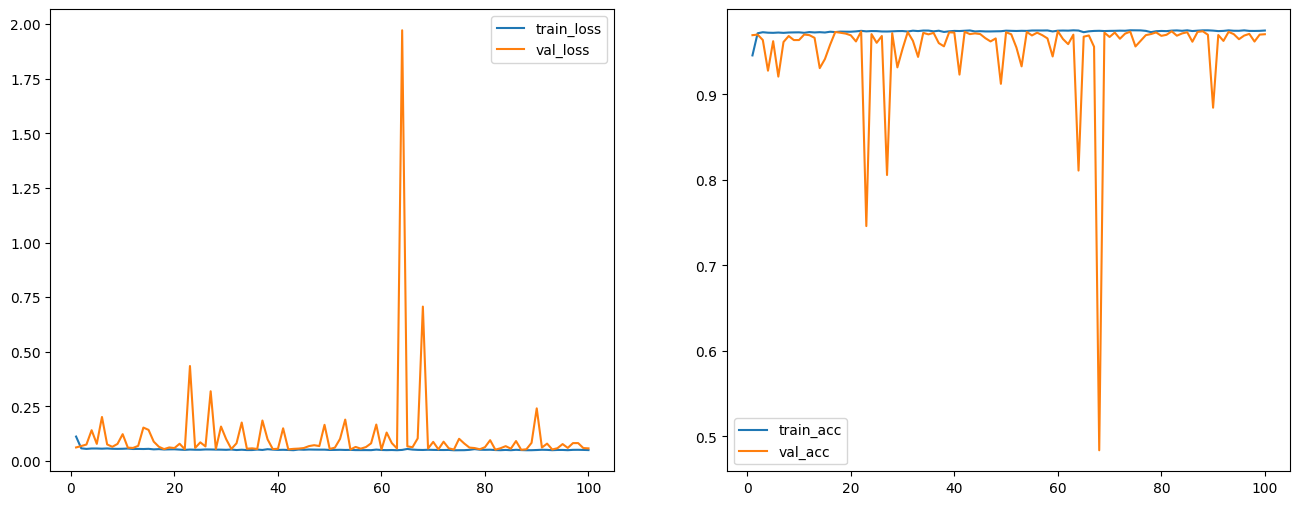

In [35]:
x = range(1,num_epochs+1)

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(x, losses_train, label='train_loss')
plt.plot(x, losses_test,label='val_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, accs_train, label='train_acc')
plt.plot(x, accs_test,label='val_acc')
plt.legend()
plt.show

##Predictions

In [36]:
num_epochs=100
#model.load_state_dict(torch.load('vi-classifier-model.pt', map_location=torch.device('cpu') ))
model.load_state_dict(torch.load('transUnet-model-'+str(num_epochs)+'-epochs-'+optimizer_name+'.pt' , map_location=torch.device('cpu') ))
test_loss, acc_test = evaluate(model, test_iter, ce_loss, dice_loss, num_classes)

print(f'\tTrain Loss {test_loss:.3f}, test accuracy {acc_test:.3f}')

	Train Loss 0.052, test accuracy 0.973


In [37]:
def predict(model, X):
  # X: [batch size, num channels, Height, Weight]
  model.eval()
  X = X.to(device)
  with torch.no_grad():
      out = model(X)
      # out: batch_size, H, W, num_classes
  #out = out.cpu().numpy()
  print(out.shape)
  preds = out.argmax(axis=-1)
  print(preds.shape)
  return preds

In [38]:
for i, batch in enumerate(test_iter):
    imgs, labels = batch
    if i==2:
      break
preds = predict(model , imgs)

torch.Size([16, 224, 224, 2])
torch.Size([16, 224, 224])


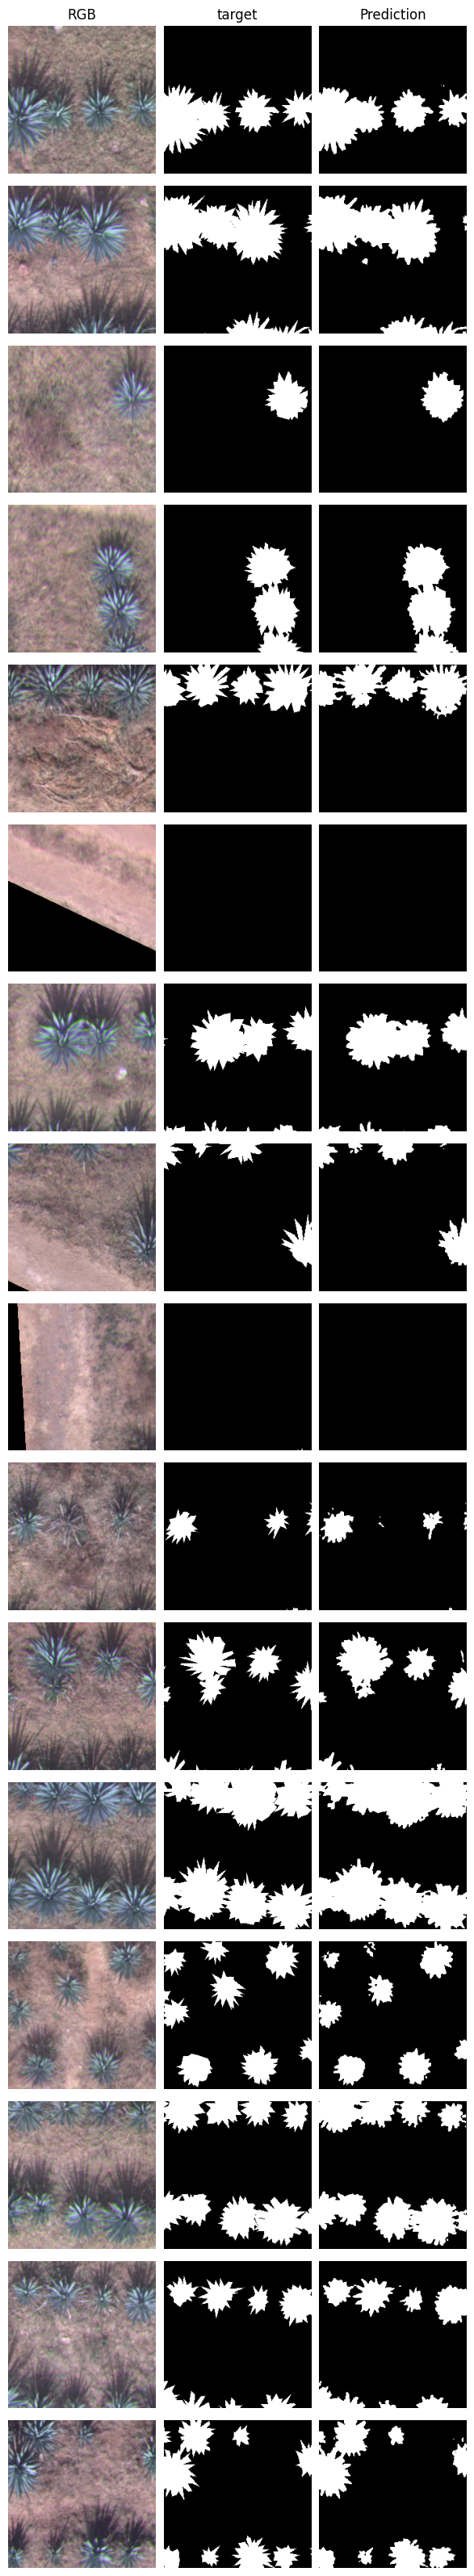

In [41]:
r, c = batch_size, 3
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
        ix = _r*c
        ax = plt.subplot(r, c, ix + 1)
        img, tar = imgs[_r], labels[_r]
        img = img[0:3,::]
        img = img.permute(1, 2, 0)/img.max()
        img = img[:, :, [2,1,0]]
        ax.axis("off")
        ax.imshow(img)
        if _r==0:
          ax.set_title("RGB")

        ax = plt.subplot(r, c, ix + 2)
        ax.axis("off")
        ax.imshow(tar.cpu(), cmap="gray")
        if _r==0:
          ax.set_title("target")

        ax = plt.subplot(r, c, ix + 3)
        ax.axis("off")
        ax.imshow(preds[_r].cpu(), cmap="gray")
        if _r==0:
          ax.set_title("Prediction")

plt.tight_layout()
plt.show()